<a href="https://colab.research.google.com/github/wanderloop/WanderlustAI/blob/master/midpoint_to_coo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pandas import DataFrame, read_csv, concat
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
!pip install pandas_profiling==2.8.0
from pandas_profiling import ProfileReport
from numpy import nan, linspace, min, max, ravel
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from plotly.figure_factory import create_table
from sklearn.impute import KNNImputer
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import IsolationForest
from gc import collect
from IPython.display import clear_output
clear_output()

In [ ]:
df = read_csv('https://raw.githubusercontent.com/wanderloop/WanderlustAI/master/assumed_PHA.csv',
              low_memory=True,)

keep_cols = ['MID_POINT_X', 
             'MID_POINT_Y',
             'lat',]
             
imp = KNNImputer(missing_values=nan,
                 n_neighbors=2,
                 weights='distance',)
df[keep_cols] = imp.fit_transform(df[keep_cols])
df = df.loc[:, keep_cols]
data = create_table(df.head())
data.show()

In [ ]:
del data
collect()

19091

In [ ]:
df.rename(columns={'MID_POINT_X': 'MPX',
                   'MID_POINT_Y': 'MPY',},
          inplace=True,)
ren = create_table(df.head())
ren.show()

In [ ]:
del ren
collect()

19346

In [ ]:
print(df.columns.values)

['MPX' 'MPY' 'lat']


In [ ]:
tail = create_table(df.tail())
tail.show()

In [ ]:
del tail
collect()

19318

In [ ]:
df1, df2 = df.head(), df.tail()
conc_data_row = concat([df1,
                        df2,],
                        axis=0, # Adds dataframes in row
                        join='outer',) # Returns columns in both df1 and df2

conc_data_row = create_table(conc_data_row)
conc_data_row.show()

In [ ]:
del conc_data_row
collect()

22300

In [ ]:
del df1
collect()

0

In [ ]:
del df2
collect()

0

In [ ]:
assert df['MPX'].notnull().all()
assert df['MPY'].notnull().all()
assert df['lat'].notnull().all()

In [ ]:
print('Duplicated entries:',
      df.duplicated().sum())
df[df.duplicated()].isna().median()

Duplicated entries: 0


MPX   NaN
MPY   NaN
lat   NaN
dtype: float64

In [ ]:
df.drop_duplicates(subset=df.columns.values[:-1],
                   keep='first',
                   inplace=True,)
print(df.shape, "Duplicated rows have been removed.")

(18, 3) Duplicated rows have been removed.


In [ ]:
# Dropping columns with more than 50% missing values
df = df.dropna(thresh=df.shape[0]*0.5,
               how='all',
               axis=1,)

In [ ]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MID_POINT_X  18 non-null     float64
 1   MID_POINT_Y  18 non-null     float64
 2   lat          18 non-null     float64
dtypes: float64(3)
memory usage: 560.0 bytes


In [ ]:
profile = ProfileReport(df,
                        title='Midpoint-Coo Report',
                        explorative=True,
                        progress_bar=True,)
profile.to_notebook_iframe()

In [ ]:
del profile
collect()

59424

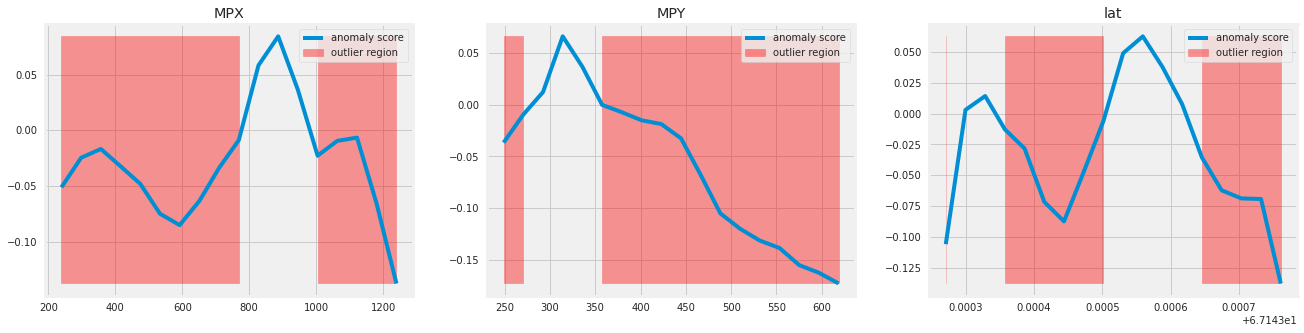

In [ ]:
cols = ['MPX',
        'MPY',
        'lat',]
fig, axs = plt.subplots(1,
                        3,
                        figsize=(20, 5),)
fig.set_facecolor('w')
fig.set_edgecolor('k')
axs = axs.ravel()

for i, column in enumerate(cols):
    isolation_forest = IsolationForest(contamination='auto')
    isolation_forest.fit(df[column].to_numpy().reshape(-1, 1))

    xx = linspace(df[column].min(),
                  df[column].max(),
                  len(df)).reshape(-1, 1)
    anomaly_score = isolation_forest.decision_function(xx)
    outlier = isolation_forest.predict(xx)
    
    axs[i].plot(xx,
                anomaly_score,
                label='anomaly score',)
    axs[i].fill_between(xx.T[0],
                        min(anomaly_score),
                        max(anomaly_score), 
                        where=outlier==-1,
                        color='r', 
                        alpha=.4,
                        label='outlier region',)
    axs[i].legend(frameon=True)
    axs[i].set_title(column)

In [ ]:
X = df[['MPX',
        'MPY',]]
y = df['lat']

In [ ]:
regr = XGBRegressor(learning_rate=0.01, 
                    n_estimators=3460,
                    max_depth=3, 
                    min_child_weight=0,
                    gamma=0, 
                    subsample=0.6,
                    colsample_bytree=0.6,
                    objective='reg:squarederror',
                    nthread=-1,
                    scale_pos_weight=1,
                    seed=26,
                    reg_alpha=0.00006,)

regr.fit(X, y.ravel(),)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=3, min_child_weight=0, missing=None, n_estimators=3460,
             n_jobs=1, nthread=-1, objective='reg:squarederror', random_state=0,
             reg_alpha=6e-05, reg_lambda=1, scale_pos_weight=1, seed=26,
             silent=None, subsample=0.6, verbosity=1)

In [ ]:
scores = cross_val_score(regr,
                         X, y.ravel(),
                         cv=18,
                         scoring='neg_root_mean_squared_error',)
print(scores)

[-1.34523437e-04 -3.17523438e-04 -4.31782227e-04 -4.03152832e-04
 -2.61152832e-04 -1.44523437e-04 -6.10670410e-04 -5.79041016e-04
 -4.48782227e-04 -3.49782227e-04 -1.54523438e-04 -3.89782227e-04
 -3.97041016e-04 -5.66041016e-04 -3.89411621e-04 -1.18782227e-04
 -9.77822266e-05 -1.10782227e-04]


In [ ]:
print('RMSE: %2f' %(-1 * scores.mean()))

RMSE: 0.000328
